## 2-2 三种计算图

静态计算图，动态计算图，以及Autograph
* 静态计算图：tf 1.x版本， 首先使用tensorflow的各种算子创建计算图，然后再开启会话session run显示执行计算图；
* 动态计算图（Eager Excution）：tf 2.x版本，每使用一个算子后，该算子会被动态加入到隐含的默认计算图中立即执行得到结果，而无需开启Session；
* Autograph: 如果想在tf2.x版本使用静态计算图，可以使用@tf.function装饰器将普通Python函数转换成对应的TensorFlow计算图构建代码，运行该函数就相当于在TensorFlow1.0中用Session执行代码。使用tf.function构建静态图的方式叫做 Autograph；

⚠️：
动态计算图的缺点是运行效率相对会低一些。因为使用动态图会有许多次Python进程和TensorFlow的C++进程之间的通信。而静态计算图构建完成之后几乎全部在TensorFlow内核上使用C++代码执行，效率更高。此外静态图会对计算步骤进行一定的优化，剪去和结果无关的计算步骤

### 一、 计算图简介

计算图由节点(nodes)和线(edges)组成。

节点表示操作符Operator，或者称之为算子，线表示计算间的依赖。

实线表示有数据传递依赖，传递的数据即张量。

虚线通常可以表示控制依赖，即执行先后顺序。

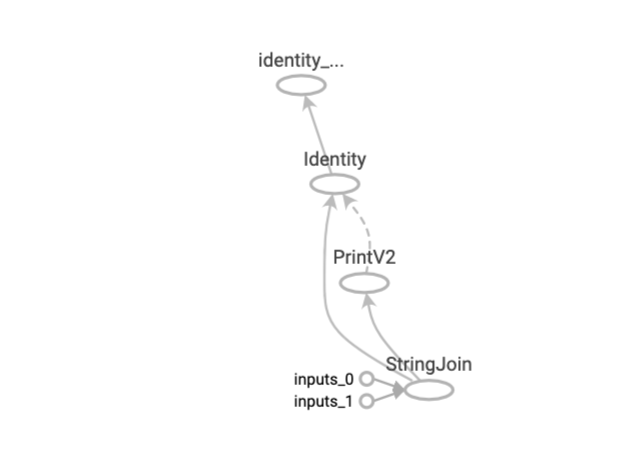

### 二、 静态计算图 1.0 version

在TensorFlow1.0中，使用静态计算图分两步：
* 第一步定义计算图
* 第二步在会话中执行计算图

* TensorFlow 1.0静态计算图范例

In [3]:
import tensorflow as tf 

#定义计算图
g = tf.Graph()
with g.as_default():
    #placeholder为占位符，执行会话时候指定填充对象
    x = tf.placeholder(name='x', shape=[], dtype=tf.string)
    y = tf.placeholder(name='y', shape=[], dtype=tf.string)
    z = tf.string_join([x,y],name = 'join',separator=' ')

#执行计算图
with tf.Session(graph = g) as sess:
    print(sess.run(z, feed_dict={x:'hello', y:'world'}))

AttributeError: module 'tensorflow' has no attribute 'placeholder'

* TensorFlow 2.0 静态计算图范例

TensorFlow2.0为了确保对老版本tensorflow项目的兼容性，在tf.compat.v1子模块中保留了对TensorFlow1.0那种静态计算图构建风格的支持。

可称之为怀旧版静态计算图，已经不推荐使用了。

In [5]:
import tensorflow as tf

g = tf.compat.v1.Graph()
with g.as_default():
    x = tf.compat.v1.placeholder(name='x', shape=[], dtype=tf.string)
    y = tf.compat.v1.placeholder(name='y', shape=[], dtype=tf.string)
    z = tf.compat.v1.string_join([x, y], name='join', separator = " ")

with tf.compat.v1.Session(graph=g) as sess:
    print(sess.run(z, feed_dict={x:'hello', y:'world'}))

b'hello world'


### 三、动态计算图
在TensorFlow2.0中，使用的是动态计算图和Autograph.

在TensorFlow1.0中，使用静态计算图分两步，第一步定义计算图，第二步在会话中执行计算图。

动态计算图已经不区分计算图的定义和执行了，而是定义后立即执行。因此称之为 Eager Excution.

Eager这个英文单词的原意是"迫不及待的"，也就是立即执行的意思。

In [6]:
x = tf.constant('hello')
y = tf.constant('world!')
z = tf.strings.join([x, y], separator=' ')

tf.print(z)

hello world!


In [7]:
# 可以将动态计算图代码的输入和输出关系封装成函数
def tf_string_join(x, y):
    z = tf.strings.join([x, y], separator=' ')
    tf.print(z)
    return z

z = tf_string_join(x, y)
print(z)

hello world!
tf.Tensor(b'hello world!', shape=(), dtype=string)


### 四、TensorFlow2.0的Autograph
动态计算图运行效率相对较低

可以用@tf.function装饰器将普通Python函数转换成和TensorFlow1.0对应的静态计算图构建代码

在TensorFlow1.0中，使用计算图分两步，第一步定义计算图，第二步在会话中执行计算图

在TensorFlow2.0中，如果采用Autograph的方式使用计算图，第一步定义计算图变成了定义函数，第二步执行计算图变成了调用函数

不需要使用会话了，一些都像原始的Python语法一样自然

实践中，我们一般会 **先用动态计算图调试代码，然后在需要提高性能的的地方利用@tf.function切换成Autograph获得更高的效率** 

当然，@tf.function的使用需要遵循一定的规范，我们后面章节将重点介绍

In [16]:
@tf.function
def string_join(x, y):
    z = tf.strings.join([x, y], separator=' ')
    tf.print(z)
    return z

z = string_join(x, y)
print(z)

hello world!
tf.Tensor(b'hello world!', shape=(), dtype=string)


In [17]:
import datetime
# 创建日志
stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

logdir = '../data/autograph/%s' % stamp
writer = tf.summary.create_file_writer(logdir)
#开启autograph跟踪
tf.summary.trace_on(graph=True, profiler=True) 

#执行autograph
result = string_join('hello', 'world')

# 将计算图信息写入日志
with writer.as_default():
    tf.summary.trace_export(
        name='autograph',
        step = 0,
        profiler_outdir=logdir)

hello world


In [18]:
#启动 tensorboard在jupyter中的魔法命令
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [20]:
%tensorboard --logdir ../data/autograph/